In [1]:
import iris
import glob
import warnings
warnings.filterwarnings('ignore')

import iris.plot as iplt

import pandas
import numpy
import seaborn

from iris.experimental.equalise_cubes import equalise_attributes
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
aa_physics = {'CanESM2': 'p4', 'CCSM4': 'p10', 'CSIRO-Mk3-6-0': 'p4',
              'GFDL-CM3': 'p1', 'GISS-E2-H': 'p107', 'GISS-E2-R': 'p107',
              'NorESM1-M': 'p1'}

exp_colors = {'historicalGHG': 'red', 'historicalMisc': 'blue',
              'historical-rcp85': 'black', 'historical': 'black'}

In [4]:
def get_time_constraint(experiment):
    """Define the time constraint"""
    
    start_date = iris.time.PartialDateTime(year=1861, month=1, day=1)
    if 'rcp85' in experiment:
        end_date = iris.time.PartialDateTime(year=2100, month=12, day=31)
    else:
        end_date = iris.time.PartialDateTime(year=2005, month=12, day=31)
    time_constraint = iris.Constraint(time=lambda t: start_date <= t.point <= end_date)
    
    return time_constraint


def get_data_dir(experiment, model, var):
    """Get the data directory"""
    
    dir_experiment = 'rcp85' if experiment == 'historical-rcp85' else experiment 
    mip = 'r1i1' + aa_physics[model] if experiment == 'historicalMisc' else 'r1i1p1'

    mydir = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/%s/latest/dedrifted' %(model, dir_experiment, mip, var)
    
    return mydir

## Deviation from pre-industrial interhemispheric OHC distribution

In [40]:
def get_data(experiment, model):
    """Get the NH and globe data cubes"""

    time_constraint = get_time_constraint(experiment)
    mydir = get_data_dir(experiment, model, 'ohc')
    
    globe_files = glob.glob('%s/ohc-globe-sum_*.nc' %(mydir))
    nh_files = glob.glob('%s/ohc-nh-sum_*.nc' %(mydir))
    
    assert len(globe_files) == len(nh_files) == 1
    
    globe_cube = iris.load_cube(globe_files[0], 'ocean heat content globe sum' & time_constraint)   
    nh_cube = iris.load_cube(nh_files[0], 'ocean heat content nh sum' & time_constraint)
    
    delta_nh = nh_cube.data[-1] - nh_cube.data[0]
    delta_globe = globe_cube.data[-1] - globe_cube.data[0]
    delta_ratio = delta_nh / delta_globe
    
    mean_nh = nh_cube.data.mean()
    mean_globe = globe_cube.data.mean()
    mean_ratio = mean_nh / mean_globe
    
    result = delta_ratio - mean_ratio
    if delta_globe < 0:
        result = result * -1
    
    return result * 100


columns = ['model', 'mip',  'historicalGHG', 'historicalMisc', 'historical', 'historical-rcp85']

def generate_data_dict(diff, model, experiment):
    """Generate dict that will form a row of a pandas dataframe."""

    data_dict = {'model': model}
    for column_label in columns[2:]:
        if column_label == experiment:
            data_dict[column_label] = diff
        else:
            data_dict[column_label] = numpy.nan
    
    return data_dict


In [42]:
data_list = []
for experiment in ['historicalGHG', 'historicalMisc', 'historical', 'historical-rcp85']:
    for model in ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']:
        diff = get_data(experiment, model)
        data_list.append(generate_data_dict(diff, model, experiment))
data_df = pandas.DataFrame(data_list) 

data_list

[{'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': 6.5373269956813749,
  'historicalMisc': nan,
  'model': 'CanESM2'},
 {'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': 1.2007449555492433,
  'historicalMisc': nan,
  'model': 'CCSM4'},
 {'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': 0.34845215102567439,
  'historicalMisc': nan,
  'model': 'CSIRO-Mk3-6-0'},
 {'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': -0.57503596033895432,
  'historicalMisc': nan,
  'model': 'GISS-E2-R'},
 {'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': 3.4869871181338663,
  'historicalMisc': nan,
  'model': 'NorESM1-M'},
 {'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': nan,
  'historicalMisc': -13.678425808595819,
  'model': 'CanESM2'},
 {'historical': nan,
  'historical-rcp85': nan,
  'historicalGHG': nan,
  'historicalMisc': -16.715830431937583,
  'model': 'CCSM4'},
 {'historical': nan,
  'historical-rcp85': n

In [37]:
data_df

,historical,historical-rcp85,historicalGHG,historicalMisc,mip,model
0,NaN,NaN,6.537327,NaN,r1i1p1,CanESM2
1,NaN,NaN,1.200745,NaN,r1i1p1,CCSM4
2,NaN,NaN,0.348452,NaN,r1i1p1,CSIRO-Mk3-6-0
3,NaN,NaN,-0.575036,NaN,r1i1p1,GISS-E2-R
4,NaN,NaN,3.486987,NaN,r1i1p1,NorESM1-M
5,NaN,NaN,NaN,-13.678426,r1i1p4,CanESM2
6,NaN,NaN,NaN,-16.715830,r1i1p10,CCSM4
7,NaN,NaN,NaN,-0.399114,r1i1p4,CSIRO-Mk3-6-0
8,NaN,NaN,NaN,-8.140113,r1i1p107,GISS-E2-R
9,NaN,NaN,NaN,-15.901458,r1i1p1,NorESM1-M


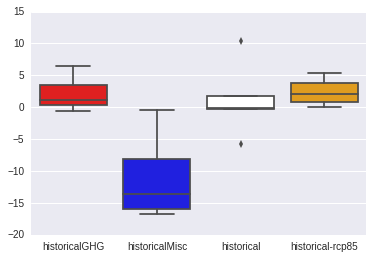

In [41]:
seaborn.boxplot(data=data_df[columns], orient="v", palette=['red', 'blue', 'white', 'orange'])

# Change in OHC fraction

# Adjusted timeseries

The NH-SH anomaly metric ($\Delta N - \Delta S$) is problematic because "no change" actually represents a falling value over time (because the SH has a greater volume).

It is difficult to present a ratio metric for OHC instead (e.g. $\Delta NH / \Delta G$), because early in the time period the global value can approach zero.

An alternative might therefore be to add an adjustment to the NH-SH anomaly at each timestep to account for the natural fall over time. That addition would be the global anomaly ($\Delta G$) multiplied by a constant that represents the fractional difference between the climatological OHC in either hemisphere ($1 - 2\bar{N} / \bar{G}$): 

$metric = (\Delta N - \Delta S) + \Delta G (1 - 2\bar{N} / \bar{G})$

In [78]:
def calc_adjusted_diff(experiment, model, ensemble_number):
    """Get the NH and globe data cubes"""

    time_constraint = get_time_constraint(experiment)
    mydir = get_data_dir(experiment, model)
    
    globe_files = glob.glob('%s/ohc-globe-sum_*.nc' %(mydir))
    nh_files = glob.glob('%s/ohc-nh-sum_*.nc' %(mydir))
    sh_files = glob.glob('%s/ohc-sh-sum_*.nc' %(mydir))
    
    assert len(globe_files) == len(nh_files) == len(sh_files) == 1
    
    globe_cube = iris.load_cube(globe_files[0], 'ocean heat content globe sum' & time_constraint)   
    nh_cube = iris.load_cube(nh_files[0], 'ocean heat content nh sum' & time_constraint)
    sh_cube = iris.load_cube(sh_files[0], 'ocean heat content sh sum' & time_constraint)
    
    globe_anomaly = globe_cube.data - globe_cube.data[0]
    nh_anomaly = nh_cube.data - nh_cube.data[0]
    sh_anomaly = sh_cube.data - sh_cube.data[0]                    
               
    nh_mean = nh_cube.data.mean()
    globe_mean = globe_cube.data.mean()
    constant = 1 - 2*(nh_mean/globe_mean)
    
    diff = nh_anomaly - sh_anomaly
    metric = diff + (globe_anomaly * constant)         
    
    metric_cube = globe_cube.copy()
    metric_cube.data = metric
    new_aux_coord = iris.coords.AuxCoord(ensemble_number, long_name='ensemble_member', units='no_unit')
    metric_cube.add_aux_coord(new_aux_coord)
    metric_cube.cell_methods = ()
                            
    return metric_cube

                         
def equalise_time_axes(cube_list):
    """Make all the time axes the same."""

    iris.util.unify_time_units(cube_list)
    reference_cube = cube_list[0]
    new_cube_list = iris.cube.CubeList([])
    for cube in cube_list:
        assert len(cube.coord('time').points) == len(reference_cube.coord('time').points)
        cube.coord('time').points = reference_cube.coord('time').points
        cube.coord('time').bounds = reference_cube.coord('time').bounds
        cube.coord('time').units = reference_cube.coord('time').units
        cube.coord('time').attributes = reference_cube.coord('time').attributes
        new_cube_list.append(cube)
    
    return new_cube_list 
                         
                         
def ensemble_aggregation(cube_list, operator):
    """Calculate the ensemble mean."""

    aggregators = {'mean': iris.analysis.MEAN, 'median': iris.analysis.MEDIAN}

    if len(cube_list) > 1:
        equalise_attributes(cube_list)
        equalise_time_axes(cube_list)
        ensemble_cube = cube_list.merge_cube()
        ensemble_agg = ensemble_cube.collapsed('ensemble_member', aggregators[operator])
        ensemble_spread = ensemble_cube.collapsed('ensemble_member', iris.analysis.PERCENTILE, percent=[25, 75])
    else:
        ensemble_agg = cube_list[0]
        ensemble_spread = None

    return ensemble_agg, ensemble_spread

In [79]:
calc_adjusted_diff('historicalGHG', 'CanESM2', 0)

<iris 'Cube' of ocean heat content globe sum / (J) (time: 145)>

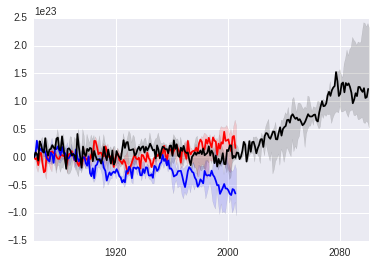

In [80]:
for experiment in ['historicalGHG', 'historicalMisc', 'historical-rcp85']:
    cube_list = iris.cube.CubeList([])
    for ensemble_number, model in enumerate(['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']):
        cube = calc_adjusted_diff(experiment, model, ensemble_number)
        cube_list.append(cube)
    ensemble_agg, ensemble_spread = ensemble_aggregation(cube_list, 'median')
    iplt.plot(ensemble_agg, label=experiment, color=exp_colors[experiment])
    time_values = ensemble_spread[0, ::].coord('time').points - 54567.5
    upper_bound = ensemble_spread[0, ::].data
    lower_bound = ensemble_spread[-1, ::].data
    iplt.plt.fill_between(time_values, upper_bound, lower_bound, facecolor=exp_colors[experiment], alpha=0.15)


In this context GHG forcing is itself an asymmetric forcing (unlike for netTOA and OHU) because OHU has a 47 / 53 split, which is NH biased relative to the 41 / 59 volume split in the ocean.

Back this up with average ocean temperature and OHU in Wm-2...

# Average temperature

In [5]:
def get_ave_temp(experiment, model):
    """Get the hemispheric average ocean temperature"""

    time_constraint = get_time_constraint(experiment)
    mydir = get_data_dir(experiment, model, 'thetao')
    
    nh_files = glob.glob('%s/thetao-nh-mean_*.nc' %(mydir))
    sh_files = glob.glob('%s/thetao-sh-mean_*.nc' %(mydir))
    
    assert len(nh_files) == len(sh_files) == 1
    
    nh_cube = iris.load_cube(nh_files[0], 'Sea Water Potential Temperature nh mean' & time_constraint)   
    sh_cube = iris.load_cube(sh_files[0], 'Sea Water Potential Temperature sh mean' & time_constraint)
    
    nh_change = nh_cube.data[-20:].mean() - nh_cube.data[0:20].mean()
    sh_change = sh_cube.data[-20:].mean() - sh_cube.data[0:20].mean()
    
    return nh_change, sh_change


temperature_columns = ['model',  'historicalGHG, NH', 'historicalGHG, SH',
                       'historicalMisc, NH', 'historicalMisc, SH',
                       'historical, NH', 'historical, SH']


def generate_temperature_dict(nh_change, sh_change, model, experiment):
    """Generate dict that will form a row of a pandas dataframe."""

    data_dict = {'model': model}
    for column_label in temperature_columns[1:]:
        nh_label = experiment + ', NH'
        sh_label = experiment + ', SH'
        if column_label == nh_label:
            data_dict[column_label] = nh_change
        elif column_label == sh_label:
            data_dict[column_label] = sh_change
        else:
            data_dict[column_label] = numpy.nan
    
    return data_dict


In [10]:
# 
data_list = []
for experiment in ['historicalGHG', 'historicalMisc', 'historical']:
    for model in ['CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']:
        nh_change, sh_change = get_ave_temp(experiment, model)
        data_list.append(generate_temperature_dict(nh_change, sh_change, model, experiment))
data_df = pandas.DataFrame(data_list) 
data_df.rename(columns={'historicalGHG, NH': 'GHG, NH', 'historicalGHG, SH': 'GHG, SH',
                        'historicalMisc, NH': 'AA, NH', 'historicalMisc, SH': 'AA, SH',
                        'historical, NH': 'hist, NH', 'historical, SH': 'hist, SH'}, inplace=True)
data_df

,"hist, NH","hist, SH","GHG, NH","GHG, SH","AA, NH","AA, SH",model
0,NaN,NaN,0.103959,0.092727,NaN,NaN,CCSM4
1,NaN,NaN,0.091388,0.096816,NaN,NaN,CSIRO-Mk3-6-0
2,NaN,NaN,0.136373,0.135989,NaN,NaN,GISS-E2-R
3,NaN,NaN,0.129586,0.111935,NaN,NaN,NorESM1-M
4,NaN,NaN,NaN,NaN,-0.012127,-0.007732,CCSM4
5,NaN,NaN,NaN,NaN,-0.085338,-0.077482,CSIRO-Mk3-6-0
6,NaN,NaN,NaN,NaN,-0.071526,-0.054037,GISS-E2-R
7,NaN,NaN,NaN,NaN,-0.078499,-0.035896,NorESM1-M
8,0.079776,0.081264,NaN,NaN,NaN,NaN,CCSM4
9,0.032591,0.031999,NaN,NaN,NaN,NaN,CSIRO-Mk3-6-0


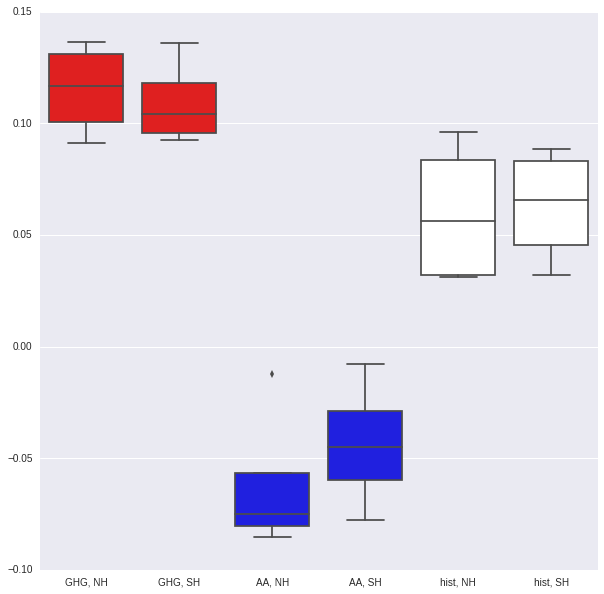

In [11]:
new_columns = ['model', 'GHG, NH', 'GHG, SH', 'AA, NH', 'AA, SH', 'hist, NH', 'hist, SH'] 
plt.figure(figsize=(10, 10))
seaborn.boxplot(data=data_df[new_columns], orient="v", palette=['red', 'red', 'blue', 'blue', 'white', 'white'])